In [11]:
"""
*Filename: BhadronClassifier
*Description: In this jupyter notebook several machine learning and deep 
*learning algorithms are used to attempt the classification of the mass of the
*bhadrons. These algorithms are compared to another using the ROC, AUC and
*accuracy scores. To better understand the classification problem principle 
*component analysis is used to visualise the complex space of features in 3D.
Date: 16/02/2023
Author: Kaylen Smith Darnbrook
"""

'\n*Filename: BhadronClassifier\n*Description: In this jupyter notebooks, several machine learning and deep \n*learning algorithms are used to attempt the classification of the mass of the\n*bhadrons. These algorithms are compared to another using the ROC, AUC and\n*accuracy scores. To better understand the classification problem principle \n*component analysis is used to visualise the complex space of features in 3D.\nDate: 16/02/2023\nAuthor: Kaylen Smith Darnbrook\n'

In [12]:
#Starts by importing the relevant python modules
import numpy as np
import DeepSetNeuralNetArchitecture as DSNNA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
import keras.backend as k
import uproot
import awkward as ak
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
#Format the style and format of the matplotlib plots
plt.style.use("default")
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rc('text',usetex = False)
plt.rc('font',family = 'Times New Roman')

In [14]:
# The data is being stored in a tree datastructure.
# We access the charm root using this command
tree = uproot.open("/storage/epp2/phswmv/data/hffrag/hffrag.root:CharmAnalysis")

In [15]:
# Initial parameters
MASKVAL = -999 # This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MAXTRACKS = 32 # This value is the maximum number of tracks allowed per event
BATCHSIZE = 64 # This is the batch size of the mini batches used during training
EPOCHS = 1000 # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 2e5 #This is the maximum number of events that will the program will accept
LR = 1e-4 #This is the default learning rate

In [16]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi", "AnalysisAntiKt4TruthJets_m","AnalysisAntiKt4TruthJets_ghostB_pdgId",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi", "AnalysisAntiKt4TruthJets_ghostB_m"]
SV_features = ["TruthParticles_Selected_LxyT"]

In [17]:
# Read in the data from the root file
features = tree.arrays(jet_features+track_features+SV_features, entry_stop=MAXEVENTS)

In [18]:
# Select the events of interest
events = features[ak.sum(
    features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]

In [19]:
# Displays the number of jets being trained on
jets = events[jet_features][:, 0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ",len(track_features))

The number of jets to train on is:  199840
The number of track features is:  8


In [20]:
# Select tracks from the events
tracks = events[track_features]
Secondary_Displacement_temp_first = events[SV_features]

# Match the tracks to the jets
mask = DSNNA.Match_Tracks(jets, tracks)
matchedtracks = tracks[mask]

# Pad and Flatten the data
matchedtracks = DSNNA.flatten(matchedtracks, MAXTRACKS)

In [21]:
#Selects the b-jets with bhadrons with a transverse momentum over 5000 MeV
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
Secondary_Displacement_temp_a = DSNNA.flatten(Secondary_Displacement_temp_first, 6).to_numpy()
Secondary_Displacement_temp_b = Secondary_Displacement_temp_a[:,0]
Secondary_Displacement_temp = Secondary_Displacement_temp_b[bjets]
jets = jets[bjets]

# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()
bhads_m = jets["AnalysisAntiKt4TruthJets_ghostB_m"][:,0].to_numpy()
bhads_PGID = jets["AnalysisAntiKt4TruthJets_ghostB_pdgId"][:,0].to_numpy()

jets_pt = jets["AnalysisAntiKt4TruthJets_pt"].to_numpy()
jets_eta = jets["AnalysisAntiKt4TruthJets_eta"].to_numpy()
jets_phi = jets["AnalysisAntiKt4TruthJets_phi"].to_numpy()
jets_m = jets["AnalysisAntiKt4TruthJets_m"].to_numpy()
b_jets = np.stack([jets_pt,jets_eta,jets_phi, jets_m], axis = -1)

bhads = np.stack([bhads_pt,bhads_eta,bhads_phi, bhads_m],axis = -1) #Combine the momentum, eta and phi for each jet into one array

print("There are {} outputs".format(np.shape(bhads)[1])) # Display the number of target features the neural network will predict
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1])) # Display the number of target features the neural network will use in it's predictions

There are 4 outputs
There are 32 inputs


In [22]:
#Select the secondary displacements for the first bhadrons
Secondary_Displacement = np.array([x[0] for x in Secondary_Displacement_temp])
print(np.min(Secondary_Displacement), np.max(Secondary_Displacement))

-999.0 115.98360443115234


In [24]:
# Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-5]])
matchedtracks = structured_to_unstructured(matchedtracks)

In [25]:
#Store both the cartesian and polar forms of the momentum of the tracks and jets
#in the tracks and bhadron jets.
polartracks = matchedtracks.to_numpy()
Num_events = MAXTRACKS
tracks_pt = polartracks[:,:,0].reshape(-1,Num_events,1)
tracks_eta = polartracks[:,:,1].reshape(-1,Num_events,1)
tracks_phi = polartracks[:,:,2].reshape(-1,Num_events,1)

tracks_pep = np.concatenate([tracks_pt,tracks_eta,tracks_phi], axis = -1) 
print(tracks_pep.shape)

jets_pt = b_jets[:,0].reshape(-1,1)
jets_eta = b_jets[:,1].reshape(-1,1)
jets_phi = b_jets[:,2].reshape(-1,1)

b_jets_pep = np.concatenate([jets_pt,jets_eta,jets_phi], axis = -1) 
print(b_jets_pep.shape)

# Convert the coordinates of the b jets and tracks to cartesian coordinates
tracks_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads = DSNNA.pt_eta_phi_2_px_py_pz_jets(bhads)
b_jets_p = DSNNA.pt_eta_phi_2_px_py_pz_jets(b_jets)
b_jets_m = b_jets[:,-1].reshape(-1,1)

#Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p,tracks_pep,matchedtracks[:,:,3:].to_numpy()],axis = 2)
b_jets = np.concatenate([b_jets_p,b_jets_pep,b_jets_m] ,axis = 1)

(96659, 32, 3)
(96659, 3)


/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:104: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


In [26]:
#Mask out the MASKVALs used to pad the arrays
tracks = np.ma.masked_values(tracks,MASKVAL)

#Calculate the fraction of the momenta that
# the bhadrons represent of the b_jet momenta
bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
print(bhads_fractions_px.shape)

(96659,)


In [27]:
# Calculate the magnitude of the b_jets momenta and 
# use it to calculate the projection of the bhadron momenta along the 
# b_jet momenta
b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_fractions = np.stack([bhads_fractions_px,bhads_fractions_py, bhads_fractions_pz], axis = -1)
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(bhads_fractions.shape)

(96659, 3)


In [28]:
#Identify the outliers in the dataset and remove them to prevent spikes during learning.
print(np.max(bhads_fractions), np.min(bhads_fractions_px))
array = [x for x in range(bhads_fractions_px.shape[0])]

#Remove the outliers in the dataset with momenta fractions and projections that are either unphysical or statistically unlikely
bhads_trial = np.stack([array,bhads_fractions_px, bhads_fractions_py, bhads_fractions_pz, bhads_projection], axis = -1)
bhads_fractions_clean  = bhads_trial[(bhads_trial[:,1] < 3) & (bhads_trial[:,1] > 0) & (bhads_trial[:,2] < 3) & (bhads_trial[:,2] > 0) & (bhads_trial[:,3] < 3) & (bhads_trial[:,3] > 0) & (bhads_trial[:,4] > 0) & (bhads_trial[:,4] < 3)]
print(bhads_fractions_clean.shape)

#Compare to the original range of the momenta fractions
print(np.max(bhads_fractions_clean[:,1]), np.min(bhads_fractions_clean[:,1]))
indices = bhads_fractions_clean[:,0]
print(indices.shape)

618.1237235802715 -4195.466731248074
(93782, 5)
2.9797144512946083 0.00039231462406675546
(93782,)


In [29]:
#Find the indices of the remaining datapoints
indices = [int(x) for x in indices]
print(indices[:5])

[0, 1, 2, 4, 5]


In [30]:
#Filter the outliers from the dataset.
tracks = tracks[indices]
b_jets = b_jets[indices]
bhads = bhads[indices]
bhads_pt = bhads_pt[indices]
bhads_eta = bhads_eta[indices]
bhads_phi = bhads_phi[indices]
bhads_PGID = bhads_PGID[indices]
b_jets_m = b_jets_m[indices]
bhads_m = bhads_m[indices]
Secondary_Displacement = Secondary_Displacement[indices]

In [31]:
#From the base features for the tracks and jet provided by the roots 
#file calculate the derived features needed for convergence.
#These features were inspired from reading on current particle physics literature

b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_mag = np.linalg.norm(bhads[:,:3], axis = 1)
tracks_Momentum = np.sum(np.linalg.norm(tracks[:,:,:3], axis = 2))

bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
print(bhads_fractions_px.shape)

b_jets_energy = np.sqrt((b_jets_m[:,0]**2) + (b_jets_mag**2))
print(b_jets_energy.shape, b_jets_m.shape)

b_jets_energy_pt = np.sqrt((b_jets_m[:,0]**2) + (b_jets[:,4]**2))
b_jets_energy_pt.shape

b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]

print(b_jet_energy_mass_ratio.shape)
bhads_energy = np.sqrt((bhads_m**2) + (bhads_mag**2))
bhads_energy.shape

bhads_energy_mass_ratio = bhads_energy/bhads_m

print(bhads_fractions[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions),np.max(bhads_fractions))

print(bhads_fractions_px[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions_px),np.max(bhads_fractions_px))

sum_px_tracks = np.sum(tracks[:,:,0], axis = 1)
sum_py_tracks = np.sum(tracks[:,:,1], axis = 1)
sum_pz_tracks = np.sum(tracks[:,:,2], axis = 1)
sum_pt_tracks = np.sum(tracks[:,:,3], axis = 1)
print(sum_pt_tracks.shape)

sum_px_tracks_RSE = np.sqrt(np.sum(tracks[:,:,0]**2, axis = 1))
sum_py_tracks_RSE= np.sqrt(np.sum(tracks[:,:,1]**2, axis = 1))
sum_pz_tracks_RSE = np.sqrt(np.sum(tracks[:,:,2]**2, axis = 1))
sum_pt_tracks_RSE = np.sqrt(np.sum(tracks[:,:,3]**2, axis = 1))
print(sum_pt_tracks_RSE.shape)

RSM_scaled_px = sum_px_tracks_RSE/sum_px_tracks
RSM_scaled_py = sum_py_tracks_RSE/sum_py_tracks
RSM_scaled_pz = sum_pz_tracks_RSE/sum_pz_tracks
RSM_scaled_pt = sum_pt_tracks_RSE/sum_pt_tracks
print(RSM_scaled_pt.shape)

RMS_scaled_px = np.sqrt(np.sum(tracks[:,:,0]**2, axis = 1)/MAXTRACKS)
RMS_scaled_py = np.sqrt(np.sum(tracks[:,:,1]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pz = np.sqrt(np.sum(tracks[:,:,2]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pt = np.sqrt(np.sum(tracks[:,:,3]**2, axis = 1)/MAXTRACKS)
print(RMS_scaled_pt.shape)

Log_px_tracks = np.log(abs(tracks[:,:,0]/b_jets[:,np.newaxis,0]))
Log_py_tracks = np.log(abs(tracks[:,:,1]/b_jets[:,np.newaxis,1]))
Log_pz_tracks = np.log(abs(tracks[:,:,2]/b_jets[:,np.newaxis,2]))
Log_pt_tracks = np.log(abs(tracks[:,:,3]/b_jets[:,np.newaxis,3]))
Log_tracks = np.stack([Log_px_tracks, Log_py_tracks, Log_pz_tracks, Log_pt_tracks], axis = -1)

Log_Sum_px = np.log(sum_px_tracks/b_jets[:,0])
Log_Sum_py = np.log(sum_py_tracks/b_jets[:,1])
Log_Sum_pz = np.log(sum_pz_tracks/b_jets[:,2])
Log_Sum_pt = np.log(sum_pt_tracks/b_jets[:,3])
Log_Momenta = np.log(abs(tracks_Momentum/np.sum(b_jets[:,:3], axis = 1)))
print(Log_Sum_pt.shape)

tracks_fractions_px = tracks[:,:,0]/b_jets[:,np.newaxis,0]
tracks_fractions_py = tracks[:,:,1]/b_jets[:,np.newaxis,1]
tracks_fractions_pz = tracks[:,:,2]/b_jets[:,np.newaxis,2]
tracks_fractions_pt = tracks[:,:,3]/b_jets[:,np.newaxis,3]
print(tracks_fractions_pt.shape)
Track_fractions = np.stack([tracks_fractions_px,tracks_fractions_py, tracks_fractions_pz], axis = -1)
print(Track_fractions.shape)

print(Track_fractions.shape)
print(tracks[0,0,0]/b_jets[0,0])
print(np.mean(Track_fractions),np.std(Track_fractions))

Tracks_projection = ((tracks[:,:,:3]*b_jets[:,np.newaxis,:3]).sum(axis = 2)/(b_jets_mag[:,np.newaxis]**2))
print(Tracks_projection.shape)
Track_Momenta = np.stack([sum_px_tracks, sum_py_tracks, sum_pz_tracks], axis = -1)
print(Track_Momenta.shape)
Sum_Tracks_projection = ((Track_Momenta*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(Sum_Tracks_projection.shape)

b_jet_energy_ratio_px = sum_px_tracks/b_jets_energy
b_jet_energy_ratio_py = sum_py_tracks/b_jets_energy
b_jet_energy_ratio_pz = sum_pz_tracks/b_jets_energy
b_jet_energy_ratio_pt = sum_pt_tracks/b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_cart = b_jets_mag/b_jets_energy
b_jet_energy_ratio_pt = b_jets[:,4]/b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_total = np.sum(b_jets[:,4])/np.sum(b_jets_energy)  
b_jet_transverse_mass = np.sqrt(b_jets_energy**2 - b_jets[:,2]**2)
bhads_transverse_mass = np.sqrt(bhads_energy**2 - bhads[:,2]**2)
print(b_jet_transverse_mass[0])
print(b_jet_energy_ratio_total.shape)
print(b_jet_transverse_mass.shape)
print(np.full((len(b_jets)),b_jet_energy_ratio_total).shape)
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)

print(np.mean(b_jets_energy),np.std(b_jets_energy))
b_jets_energy = (b_jets_energy - np.mean(b_jets_energy))/(np.std(b_jets_energy))

print(np.mean(bhads_energy),np.std(bhads_energy))
bhads_energy = (bhads_energy - np.mean(bhads_energy))/(np.std(bhads_energy))

b_jets = np.stack([b_jets[:,0], b_jets[:,1], b_jets[:,2],b_jets[:,3],b_jets[:,4], b_jets[:,5], b_jets[:,6], b_jets_mag, sum_px_tracks, sum_py_tracks, sum_pz_tracks, sum_pt_tracks, sum_px_tracks_RSE, sum_py_tracks_RSE, sum_pz_tracks_RSE, sum_pt_tracks_RSE, RSM_scaled_px, RSM_scaled_py, RSM_scaled_pz, RSM_scaled_pt, RMS_scaled_px, RMS_scaled_py, RMS_scaled_pz, RMS_scaled_pt, b_jet_transverse_mass, Log_Sum_px, Log_Sum_py, Log_Sum_pz, Log_Sum_pt, Log_Momenta, b_jets_energy, b_jet_energy_ratio_px, b_jet_energy_ratio_py, b_jet_energy_ratio_pz, b_jet_energy_ratio_cart, b_jet_energy_ratio_pt, b_jet_energy_mass_ratio, np.full((len(b_jets),),b_jet_energy_ratio_total)], axis = -1)
bhads_targets = np.stack([bhads[:,0],bhads[:,1], bhads[:,2], bhads_fractions_px, bhads_fractions_py, bhads_fractions_pz, bhads_energy, bhads_transverse_mass, bhads_energy_mass_ratio, bhads_projection, bhads_m], axis = -1)
bhads_targets = np.ma.masked_values(bhads_targets, -999)

(93782,)
(93782,) (93782, 1)
(93782,)
[0.9923946  1.00824593 0.99120818]
0.9923945992521676
-34465.39587820514 618.1237235802715
0.9923945992521676
0.9923945992521676
0.00039231462406675546 2.9797144512946083
(93782,)


/tmp/ipykernel_26390/3948456506.py:20: RuntimeWarning: divide by zero encountered in true_divide
  b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]


(93782,)
(93782,)
(93782,)


/tmp/ipykernel_26390/3948456506.py:66: RuntimeWarning: divide by zero encountered in log
  Log_Sum_px = np.log(sum_px_tracks/b_jets[:,0])
/tmp/ipykernel_26390/3948456506.py:66: RuntimeWarning: invalid value encountered in log
  Log_Sum_px = np.log(sum_px_tracks/b_jets[:,0])
/tmp/ipykernel_26390/3948456506.py:67: RuntimeWarning: divide by zero encountered in log
  Log_Sum_py = np.log(sum_py_tracks/b_jets[:,1])
/tmp/ipykernel_26390/3948456506.py:67: RuntimeWarning: invalid value encountered in log
  Log_Sum_py = np.log(sum_py_tracks/b_jets[:,1])
/tmp/ipykernel_26390/3948456506.py:68: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pz = np.log(sum_pz_tracks/b_jets[:,2])
/tmp/ipykernel_26390/3948456506.py:68: RuntimeWarning: invalid value encountered in log
  Log_Sum_pz = np.log(sum_pz_tracks/b_jets[:,2])
/tmp/ipykernel_26390/3948456506.py:69: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pt = np.log(sum_pt_tracks/b_jets[:,3])


(93782,)
(93782, 32)
(93782, 32, 3)
(93782, 32, 3)
0.14894195156291137
-671.8031769887268 468.8612610654489
(93782, 32)
(93782, 3)
(93782,)
(93782,)
(93782,)
79564.74
()
(93782,)
(93782,)
216243.42 189359.58
164350.25546406503 149711.23421940327


In [32]:
"""
Below is the derived and base features used by
the machine and deep learning models for the tracks.
0 - Track Momentum Px
1 - Track Momentum Py
2 - Track Momentum Pz
3-  Track Momentum Pt
4-  Track Momentum Eta
5 - Momentum Phi Scaled
6 - Track Tranvserse Impact parameter sin component
7 - Track Longitudinal Impact parameter
8 - Track Longitudinal Impact parameter signficiance
9 - Track Longitudinal Impact Parameter w.r.t PV
10 - Track Longitudinal Impact Parameter wr.r.t PV
11 - Track Momentum Fraction Px of b_jets Px
12 - Track Momentum Fraction Py of b_jets Py
13 - Track Momentum Fraction Pz of b_jets Pz
14 - Track Momentum Fraction Pt of b_jets Pt .
15 - Track Logarithm of px of the tracks / b_jet x momenta
16 - Track Logarithm of py of the tracks / b_jet y momenta
17 - Track Logarithm of pz of the tracks / b_jet z momenta
18 - Track Logarithm of sum pt of the tracks / b_jet sum pt momenta
"""
#Combine the features into one array
Tracks_input = np.concatenate([tracks, Track_fractions, Log_tracks], axis = -1)
print(Tracks_input.shape)

(93782, 32, 18)


In [33]:
"""
Below is the derived and base features used by
the machine and deep learning models for the b_jets.
0 - B_jet Momentum Px
1 - B_jet Momentum Py
2 - B_jet Momentum Pz
3 - B_jet Momentum Pt
4 - B_jet Momentum Eta
5 - B_jet Momentum Phi
6 - Sum px of the tracks
7 - Sum py of the tracks
8 - Sum pz of the tracks
9 - Sum pt of the tracks
10 - Sqrt of the Sum px of the tracks
11 - Sqrt of the Sum py of the tracks
12 - Sqrt of the Sum pz of the tracks
13 - Sqrt of the Sum pt of the tracks
14 - Sqrt of the Sum px of the tracks scaled by the sum px of the tracks
15 - Sqrt of the Sum py of the tracks scaled by the sum py of the tracks
16 - Sqrt of the Sum pz of the tracks scaled by the sum pz of the tracks
17 - Sqrt of the Sum pt of the tracks scaked by the sum pt of the tracks
18 - Root Mean Square of the px momenta of the tracks
19 - Root Mean Square of the py momenta of the tracks
20 - Root Mean Square of the pz momenta of the tracks
21 - Root Mean Square of the pt momenta of the tracks
22 - Tranvserse mass of the b-jets
23 - Logarithm of the  Sum px of the tracks divide by the b_jet x momenta
24 - Logarithm of the  Sum py of the tracks divide by the b_jet y momenta
25 - Logarithm of the  Sum pz of the tracks divide by the b_jet z momenta
26 - Logarithm of the total momenta of the tracks divided by the b_jet total momenta
27 - B_jet energy
28 - B_jet energy ratio px
29 - B_jet energy ratio py
30 - B_jet energy ratio pz
31 - B_jet energy ratio pt
32 - B_jet energy ratio cart
32 - B_jet energy ratio pt
33 - B_jet energy ratio total
"""
#Combine the features into an array
b_jets_input = np.concatenate([b_jets, Tracks_projection, Sum_Tracks_projection.reshape(-1,1)], axis = -1)
print(b_jets_input.shape)

(93782, 71)


In [34]:
#Removes any infinites from the b_jets and track data
mask = np.where(np.isinf(b_jets_input) == True)
b_jets_input_clean = np.delete(b_jets_input, mask, axis = 0)
print(b_jets_input_clean.shape)
Tracks_input_clean = np.delete(Tracks_input, mask, axis = 0)
bhads_m_clean = np.delete(bhads_m, mask, axis = 0)
bhads_targets_clean = np.delete(bhads_targets, mask, axis = 0) 
print(Tracks_input_clean.shape,b_jets_input_clean.shape,bhads_m_clean.shape, bhads_targets_clean.shape)

(93780, 71)
(93780, 32, 18) (93780, 71) (93780,) (93780, 11)


In [35]:
#Preliminary analysis of the dataset shows that it is imbalanced. 
# To remedy this 3 duplicate examples are created and then SMOTE is used
#to interpolate the rest.
duplicate = 3
for _ in range(duplicate):
    mask_6 = (bhads_m_clean==6277.0)
    bhads_m_clean = np.append(bhads_m_clean, bhads_m_clean[mask_6], axis = 0)
    b_jets_input_clean = np.append(b_jets_input_clean, b_jets_input_clean[mask_6], axis = 0)
    Tracks_input_clean = np.append(Tracks_input_clean, Tracks_input_clean[mask_6], axis = 0)
    bhads_targets_clean = np.append(bhads_targets_clean, bhads_targets_clean[mask_6], axis = 0)
    mask_9 = (bhads_m_clean == 9912.2001953125)
    bhads_m_clean = np.append(bhads_m_clean, bhads_m_clean[mask_9], axis = 0)
    b_jets_input_clean = np.append(b_jets_input_clean, b_jets_input_clean[mask_9], axis = 0)
    Tracks_input_clean = np.append(Tracks_input_clean, Tracks_input_clean[mask_9], axis = 0)
    bhads_targets_clean = np.append(bhads_targets_clean, bhads_targets_clean[mask_9], axis = 0)
    
print(Tracks_input_clean.shape,b_jets_input_clean.shape, bhads_m_clean.shape, bhads_targets_clean.shape)

(93815, 32, 18) (93815, 71) (93815,) (93815, 11)


In [53]:
#Identify the number of bhadrons with masses x
from collections import Counter
counter_pca = Counter(bhads_m_clean)
print(counter_pca)

#Convert the discrete bhadron masses into a onehot encoding.
from sklearn.preprocessing import OneHotEncoder
counter = np.array([])
bhadron_PGIDs = []
for PGID in bhads_PGID:
    if (PGID == 521 or PGID == -521):
        element = 0
    elif (PGID == 511 or PGID == -511):
        element = 1
    elif (PGID == 531 or PGID == -531):
        element = 2
    else:
        element = 4
    counter = np.append(counter, [element])
    bhadron_PGIDs.append([str(element)])
print(np.shape(bhadron_PGIDs))
counter = Counter(counter)
print(counter)
encoder = OneHotEncoder(sparse = False)
onehot = encoder.fit_transform(bhadron_PGIDs)
print(np.shape(onehot))

Counter({5279.580078125: 40083, 5279.169921875: 27505, 5279.25: 12456, 5366.77001953125: 9075, 5619.39990234375: 2221, 5620.2001953125: 1402, 5791.10009765625: 424, 5788.0: 422, 5790.5: 175, 6277.0: 32, 6070.0: 12, 9912.2001953125: 8})
(93782, 1)
Counter({1.0: 40084, 0.0: 39962, 2.0: 9075, 4.0: 4661})
(93782, 4)


In [37]:
#Standardize the track and b_jet data
Scaler_tracks = StandardScaler()
Num_events,Num_tracks,Num_features = np.shape(Tracks_input_clean)
Scaled_tracks = np.reshape(Tracks_input_clean, newshape=(-1,Num_features))
tracks_scaled = Scaler_tracks.fit_transform(Scaled_tracks)
Tracks_input_scaled = np.reshape(tracks_scaled, newshape= (Num_events,Num_tracks,Num_features))
print(np.shape(Tracks_input_scaled))

Scaler_jets = StandardScaler()
Num_events,Num_features = np.shape(b_jets_input_clean)
b_jets_scaled = np.reshape(b_jets_input_clean, newshape=(-1,Num_features))
b_jets_scaled = Scaler_jets.fit_transform(b_jets_scaled)
b_jets_input_scaled = np.reshape(b_jets_scaled, newshape= (Num_events,Num_features))
print(np.shape(b_jets_input_scaled))

means = []
stds = []
lister = []
for bhads_target_feature in range(np.shape(bhads_targets_clean)[1]):
    Bhads_targets = bhads_targets_clean[:,bhads_target_feature]
    mean, std = np.mean(Bhads_targets), np.std(Bhads_targets)
    means = np.append(means,mean)
    stds = np.append(stds,std)
    Standardized_Bhads_targets = (Bhads_targets - mean)/(std)
    Standardized_Bhads_targets = Standardized_Bhads_targets.reshape(-1,1)
    lister.append(Standardized_Bhads_targets)
Standardized_Bhads_targets = np.concatenate(lister,axis = 1)
print(Standardized_Bhads_targets.shape)
print(means,stds)

(93815, 32, 18)
(93815, 71)
(93815, 11)
[-1.21249696e+02 -7.58596267e+01 -6.13882807e+01  7.95223707e-01
  7.95230457e-01  7.91796359e-01 -1.73631657e-04  8.31059196e+04
  3.09673362e+01  7.87650522e-01  5.30737369e+03] [6.58091752e+04 6.56788846e+04 2.01833381e+05 2.60394371e-01
 2.62140901e-01 2.59338962e-01 9.99856386e-01 4.20257985e+04
 2.82050236e+01 2.39233793e-01 9.75306752e+01]


In [38]:
#Create a label embedding for the bhadron masses
from sklearn.preprocessing import LabelEncoder
LabelEncoded =LabelEncoder()
LabelEncoded.fit(bhads_m_clean)
LabelEncoded.classes_
Bhad_Mass_Labels = LabelEncoded.transform(bhads_m_clean)

In [39]:
#Flatten the tracks into a 1D array
The_Tracks = Tracks_input_scaled.reshape(np.shape(b_jets_input_scaled)[0], -1)
Inputs = np.concatenate([b_jets_input_scaled, The_Tracks], axis = -1)

In [45]:
#Using principle component analysis reduce the dataset to 3 principle components.
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
Inputs_pca = pca.fit_transform(Inputs)
print(pca.explained_variance_ratio_)

[0.23014423 0.13083739 0.07436849]


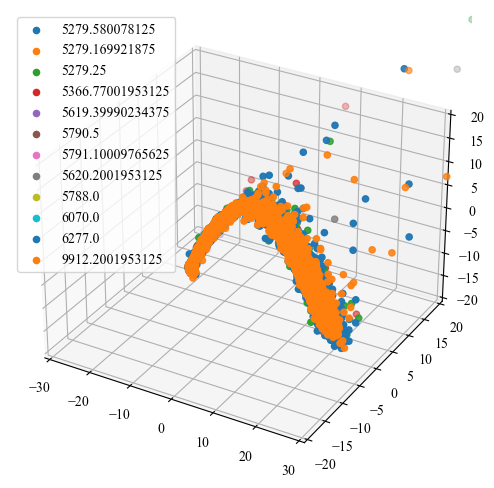

In [55]:
#Plot a 3D scatterplot showing the variation of the 3 principle components
from mpl_toolkits import mplot3d
fig = plt.figure(figsize = (6,6))
ax = plt.axes(projection="3d")
for label, _ in counter_pca.items():
    row_ix = np.where(bhads_m_clean == label)[0]
    ax.scatter3D(Inputs_pca[row_ix,0], Inputs_pca[row_ix,1], Inputs_pca[row_ix,2], label = str(label))
ax.set_xlim([-30,30])
ax.set_ylim3d([-20,20])
ax.set_zlim3d([-20,20])
plt.legend()
plt.show()

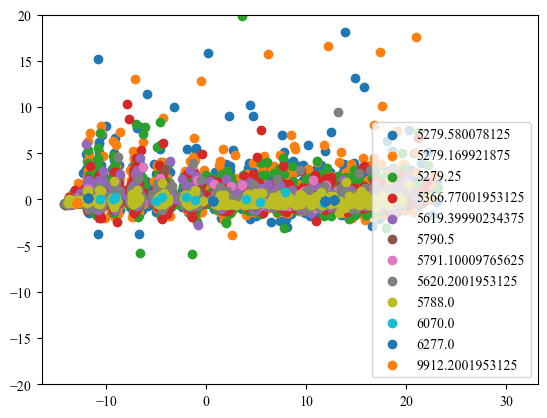

In [69]:
#Studying the variation in the data with respect just two of the principle components 
for label, _ in counter_pca.items():
    row_ix = np.where(bhads_m_clean == label)[0]
    plt.scatter(Inputs_pca[row_ix,0], Inputs_pca[row_ix,1], label = str(label))
plt.ylim([-20,20])
plt.legend()
plt.show()

In [56]:
#Use SMOTE to reblance the classes to be relatively equal in number of instances per class
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
over_sampled = SMOTE(random_state = 42)
under_sampled = RandomUnderSampler(random_state=42)
steps = [('o', over_sampled), ('u', under_sampled)]
Piper = Pipeline(steps = steps)
X,y = Piper.fit_resample(Inputs, Bhad_Mass_Labels)
counter2 = Counter(y)
print(counter2)

Counter({0: 40083, 1: 40083, 2: 40083, 3: 40083, 4: 40083, 5: 40083, 6: 40083, 7: 40083, 8: 40083, 9: 40083, 10: 40083, 11: 40083})


In [57]:
#Using principle component analysis reduce the dataset to 3 principle components.
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
Inputs_pca_X = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.37466992 0.1228507  0.05730266]


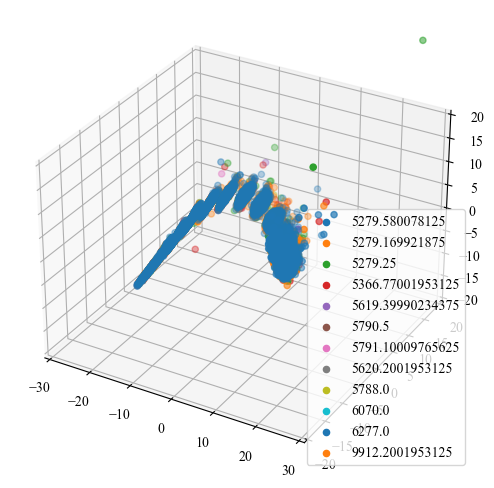

In [62]:
#Rebalanced class scatterplots showing how the principle components of the rebalanced dataset 
#capture the underylying dataset
from mpl_toolkits import mplot3d
fig = plt.figure(figsize = (6,6))
ax = plt.axes(projection="3d")
for label, _ in counter_pca.items():
    row_ix = np.where(bhads_m_clean == label)[0]
    ax.scatter3D(Inputs_pca_X[row_ix,0], Inputs_pca_X[row_ix,1], Inputs_pca_X[row_ix,2], label = str(label))
ax.set_xlim([-30,30])
ax.set_ylim3d([-20,20])
ax.set_zlim3d([-20,20])
plt.legend()
plt.show()

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


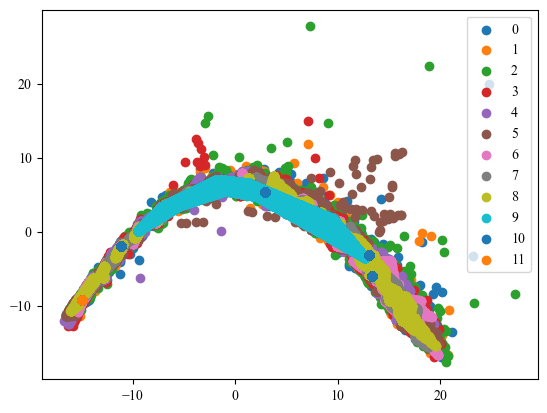

In [70]:
#Studying the variation in the data with respect just two of the principle components 
for label, _ in counter2.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(Inputs_pca_X[row_ix,0], Inputs_pca_X[row_ix,1], label = str(label))
plt.legend()
plt.show()

In [73]:
#Train a support vector machine using stochastic gradient descent on the SMOTE balanced dataset
MassClassifier = make_pipeline(StandardScaler(), SGDClassifier(random_state=42, early_stopping=True, validation_fraction=0.1, max_iter=1000, tol = 1e-3))
MassClassifier.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(early_stopping=True, random_state=42))])

In [74]:
#Train a support vector machine using stochastic gradient descent on the original dataset with class weight set to balanced
MassClassifier_balanced = make_pipeline(StandardScaler(), SGDClassifier(random_state=42, class_weight="balanced", early_stopping=True, validation_fraction=0.1, max_iter=1000, tol = 1e-3))
MassClassifier_balanced.fit(b_jets_input_clean, Bhad_Mass_Labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(class_weight='balanced', early_stopping=True,
                               random_state=42))])

In [76]:
#Train a random forest classifier on the SMOTE balanced dataset
from sklearn.ensemble import RandomForestClassifier
MassClassifier_Forest = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=12, random_state=42, n_estimators=200))
MassClassifier_Forest.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=12, n_estimators=200,
                                        random_state=42))])

In [77]:
#Determine the performance of the models
print(MassClassifier.score(X,y))

print(MassClassifier_balanced.score(b_jets_input_clean, Bhad_Mass_Labels))

print(MassClassifier_Forest.score(X,y))

0.38904897338023603
0.18315834354847305
0.7536195727199395


In [78]:
#Convert the predictions of the MassClassifier Forest into a onehot embedding
Predictions_Mass = MassClassifier_Forest.predict(X)
bhadron_masses_predictions = []
for mass in Predictions_Mass:
    bhadron_masses_predictions.append([str(mass)])
print(np.shape(bhadron_masses_predictions))
encoder = OneHotEncoder(sparse = False)
predictions = encoder.fit_transform(bhadron_masses_predictions)
predictions = np.array(predictions)
print(np.shape(predictions))

(480996, 1)
(480996, 12)


In [79]:
#Convert the bhadron masses into a onehot embedding
bhadron_masses_true = []
for mass in y:
    bhadron_masses_true.append([str(mass)])
print(np.shape(bhadron_masses_true))
encoder = OneHotEncoder(sparse = False)
true = encoder.fit_transform(bhadron_masses_true)
true = np.array(true)
print(np.shape(true))

(480996, 1)
(480996, 12)


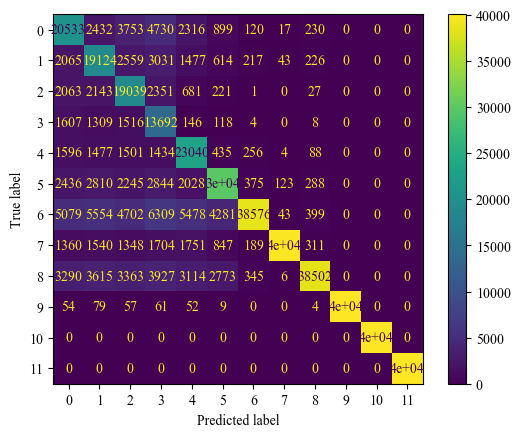

In [80]:
#Compute the confusion matrix for the random forest model's 
#predictions
from sklearn.metrics import confusion_matrix
from sklearn import metrics
confusion_mat = confusion_matrix(Predictions_Mass, y)
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

In [81]:
#Evaulates the performance of the model's predictions across the different models.
from sklearn.metrics import classification_report
target_names = ["Mass_0", "Mass_1", "Mass_2", "Mass_3", "Mass_4", "Mass_5", "Mass_6", "Mass_7", "Mass_8", "Mass_9", "Mass_10", "Mass_11"]
print(classification_report(y, Predictions_Mass, target_names=target_names))

              precision    recall  f1-score   support

      Mass_0       0.59      0.51      0.55     40083
      Mass_1       0.65      0.48      0.55     40083
      Mass_2       0.72      0.47      0.57     40083
      Mass_3       0.74      0.34      0.47     40083
      Mass_4       0.77      0.57      0.66     40083
      Mass_5       0.69      0.75      0.72     40083
      Mass_6       0.55      0.96      0.70     40083
      Mass_7       0.81      0.99      0.90     40083
      Mass_8       0.65      0.96      0.78     40083
      Mass_9       0.99      1.00      1.00     40083
     Mass_10       1.00      1.00      1.00     40083
     Mass_11       1.00      1.00      1.00     40083

    accuracy                           0.75    480996
   macro avg       0.76      0.75      0.74    480996
weighted avg       0.76      0.75      0.74    480996



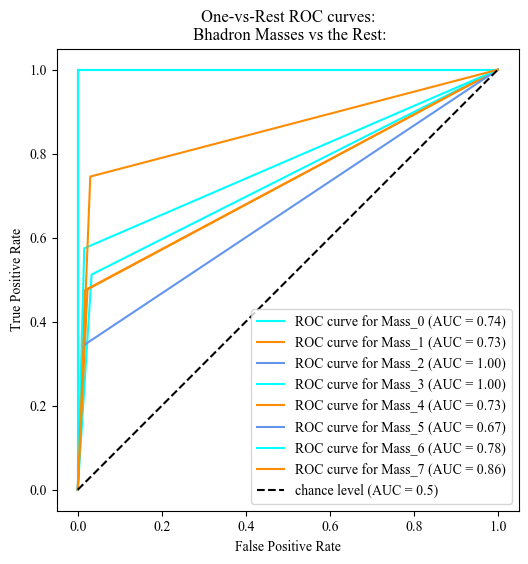

In [82]:
#Produces the ROC curve for the support vector machines predictions
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize = (6,6))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, colors in zip(range(8), colors):
    RocCurveDisplay.from_predictions(
        true[:,class_id],
        predictions[:, class_id],
        name = f"ROC curve for {target_names[class_id]}",
        color = colors,
        ax = ax,
    )
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\n Bhadron Masses vs the Rest:")
plt.legend()
plt.show()